# PowerModelsDistribution.jl Transformer Modelling Tutorial

`PowerModelsDistribution.jl` allows modelling power transformers with any number of windings and number of phases taking into account the loss models for each winding. While this is a powerful feature, it can be complex to model and confusing for starting users. Hence, this tutorial is to provide a simple introduction to power transformer models in `PowerModelsDistribution.jl`. For the full details on how the transformer model was implemented please refer to S. Claeys, G. Deconinck and F. Geth, “Decomposition of n-winding transformers for unbalanced optimal power flow,” IET Generation, Transmission & Distribution, vol. 14, no. 24, pp. 5961-5969, 2020, DOI: 10.1049/iet-gtd.2020.0776.


## Transformer Modelling Theory

Starting with the simplest case of a two-winding, single-phase transformer, which will later serve as the fundamental building block for $n$-winding, $n$-phase transformers.

Without delving deeply into the electromagnetic theory of transformer operation, the functioning of a transformer can be simplified as follows: a primary coil (coil 1) and a secondary coil (coil 2) are wound on the same magnetic core. When a voltage $U_1$ is applied to the primary coil, it generates a magnetic flux $\Phi_1$. Part of this flux links the primary coil with itself (not going through the core to the secondary coil), denoted as $\Phi_{11}$, while another part, denoted as $\Phi_{m}$, links the secondary coil. The magnetic flux $\Phi_{m}$ induces a voltage $U_2$ in the secondary coil, which can drive a current $I_2$ when a load is connected to the secondary coil.

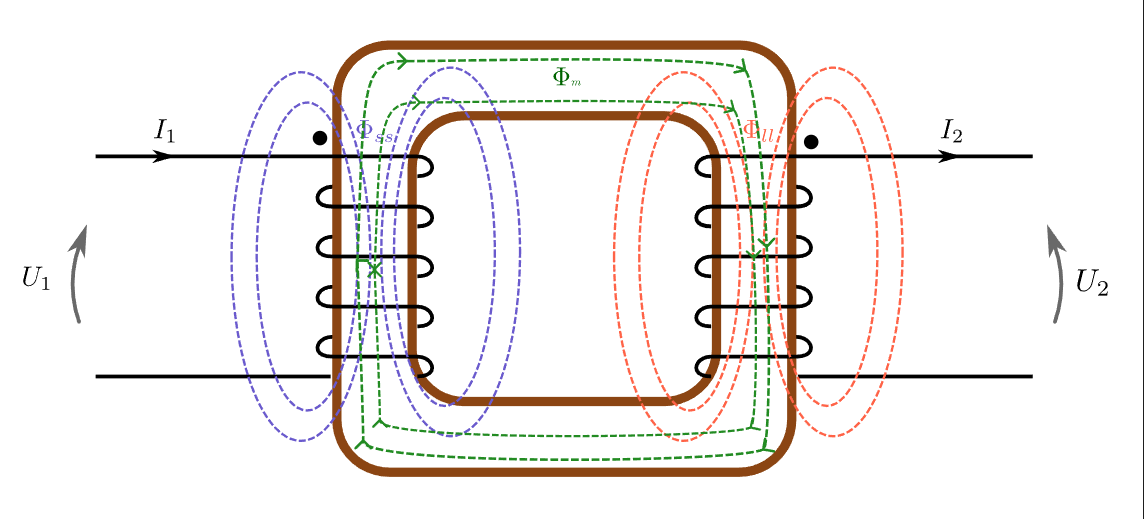

![Transformer Fields](transformer_fields.svg)

![Transformer Fields png](trans.png)

Taking into account that each of the coils has a resistance $R_1$ and $R_2$ and modelling the leakage flux $\Phi_{11}$ and $\Phi_{22}$



In [285]:
using Pkg
Pkg.activate(".")
Pkg.develop("PowerModelsDistribution") #TODO: make it add insead of develop
Pkg.add("Ipopt")


  Activating project at `c:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Project.toml`
    Manifest No packages added to or removed from `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Project.toml`
    Manifest No packages added to or removed from `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Manifest.toml`


In [286]:
Pkg.status()

Status `C:\Users\mnumair\OneDrive - KU Leuven\PhD Agenda\2025\12-25 December\PMD Transformer Model Tutorial\Project.toml`
  [b6b21f68] Ipopt v1.13.0
  [d7431456] PowerModelsDistribution v0.16.0 `C:\Users\mnumair\.julia\dev\PowerModelsDistribution` [loaded: `C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\PowerModelsDistribution.jl` (v0.16.0) expected `C:\Users\mnumair\.julia\dev\PowerModelsDistribution\src\PowerModelsDistribution.jl` (v0.16.0)]


In [287]:
using PowerModelsDistribution
using Ipopt

In [ ]:
function show_transformer_math_components(math)
    transformer_index_byname = findall(x->haskey(x, "unmap_function") && x["unmap_function"] == "_map_math2eng_transformer!", math["map"])
    display("Transformer " * math["map"][transformer_index_byname...]["from"]*" Was converted to: ")
    #display(math["map"][transformer_index_byname...]["to"])
    for element in math["map"][transformer_index_byname...]["to"]
        element_type = split(element, ".")[1]
        element_idx = split(element, ".")[2]
        display("================================" * element_type * " "* element_idx *"================================")
        # display("Element Index: " * element_idx)    
        display(math[element_type][element_idx])
    end
end

show_transformer_math_components (generic function with 1 method)

In [289]:
pmd_file_path = joinpath(pathof(PowerModelsDistribution), "..\\test\\data")

"C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistribution\\EOTxp\\src\\PowerModelsDistribution.jl\\..\\test\\data"

## Single-Phase Two-Winding Wye-Wye Transformer

In [290]:
eng_1ph_2w_yy = parse_file("trans_1ph_2w_yy.dss", transformations=[transform_loops!] )

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 1 in 'trans_1ph_2w_yy.dss'
[ PowerModelsDistribution | Info ] : Command 'batchedit' on line 32 in 'trans_1ph_2w_yy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 39 in 'trans_1ph_2w_yy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 42 in 'trans_1ph_2w_yy.dss' is not supported, skipping.
┌ PowerModelsDistribution | Warning ] : basefreq=60.0 on line.line2 does not match circuit basefreq=50.0
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\dev\PowerModelsDistribution\src\data_model\transformations\dss2eng.jl:422
┌ PowerModelsDistribution | Warning ] : basefreq=60.0 on line.line1 does not match circuit basefreq=50.0
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\dev\PowerModelsDistribution\src\data_model\transformations\dss2eng.jl:422


Dict{String, Any} with 11 entries:
  "xfmrcode"       => Dict{String, Any}("tx"=>Dict{String, Any}("sm_ub"=>750.0,…
  "conductor_ids"  => [1, 2, 3, 4]
  "bus"            => Dict{String, Any}("sourcebus"=>Dict{String, Any}("rg"=>[0…
  "name"           => "ut_trans"
  "settings"       => Dict{String, Any}("sbase_default"=>1000.0, "vbases_defaul…
  "files"          => ["trans_1ph_2w_yy.dss"]
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("cm_ub"=>[60…
  "data_model"     => ENGINEERING
  "transformer"    => Dict{String, Any}("tx1"=>Dict{String, Any}("polarity"=>[1…
  "load"           => Dict{String, Any}("load1"=>Dict{String, Any}("source_id"=…

In [291]:
eng_1ph_2w_yy["transformer"]["tx1"]["vm_nom"][1] /eng_1ph_2w_yy["transformer"]["tx1"]["vm_nom"][2]

27.5

In [292]:
math_1ph_2w_yy = transform_data_model(eng_1ph_2w_yy)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => true
  "conductor_ids"   => [1, 2, 3]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "ut_trans"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>1000.0, "vbases_defau…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0;;]…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => true
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}()
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("sourcebus"=>1, "1"=>2, "2"=>3, "3"=>4)
  "load"            => Dict{String, Any}("1"=>Dict{Strin

In [293]:
show_transformer_math_components(math_1ph_2w_yy)

"Transformer tx1 Was converted to: "

"================================bus 5================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0]
  "vmin"       => [0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 5
  "index"      => 5
  "name"       => "_virtual_bus.transformer.tx1_4"
  "bus_type"   => 1
  "terminals"  => [1]
  "vmax"       => [Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 6================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0]
  "vmin"       => [0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 6
  "index"      => 6
  "name"       => "_virtual_bus.transformer.tx1_2"
  "bus_type"   => 1
  "terminals"  => [1]
  "vmax"       => [Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 7================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0]
  "vmin"       => [0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 7
  "index"      => 7
  "name"       => "_virtual_bus.transformer.tx1_3"
  "bus_type"   => 1
  "terminals"  => [1]
  "vmax"       => [Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 8================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0]
  "vmin"       => [0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 8
  "index"      => 8
  "name"       => "_virtual_bus.transformer.tx1_1"
  "bus_type"   => 1
  "terminals"  => [1]
  "vmax"       => [Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================branch 3================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.12;;]
  "br_x"          => [0.0;;]
  "g_to"          => [0.0;;]
  "c_rating_a"    => [Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_2"
  "br_status"     => 1
  "b_to"          => [0.0;;]
  "index"         => 3
  "tap"           => [1.0]
  "shift"         => [0.0]
  "f_connections" => [1]
  "name"          => "_virtual_branch.transformer.tx1_2"
  "switch"        => false
  "g_fr"          => [0.00833333;;]
  "b_fr"          => [-0.0183333;;]
  "t_connections" => [1]
  "f_bus"         => 6
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 4================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.0;;]
  "br_x"          => [0.3;;]
  "g_to"          => [0.0;;]
  "c_rating_a"    => [Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_3"
  "br_status"     => 1
  "b_to"          => [0.0;;]
  "index"         => 4
  "tap"           => [1.0]
  "shift"         => [0.0]
  "f_connections" => [1]
  "name"          => "_virtual_branch.transformer.tx1_3"
  "switch"        => false
  "g_fr"          => [0.0;;]
  "b_fr"          => [0.0;;]
  "t_connections" => [1]
  "f_bus"         => 7
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 5================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.06;;]
  "br_x"          => [0.0;;]
  "g_to"          => [0.0;;]
  "c_rating_a"    => [Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_1"
  "br_status"     => 1
  "b_to"          => [0.0;;]
  "index"         => 5
  "tap"           => [1.0]
  "shift"         => [0.0]
  "f_connections" => [1]
  "name"          => "_virtual_branch.transformer.tx1_1"
  "switch"        => false
  "g_fr"          => [0.0;;]
  "b_fr"          => [0.0;;]
  "t_connections" => [1]
  "f_bus"         => 8
  "t_bus"         => 7
  ⋮               => ⋮

"================================transformer 1================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.1"
  "t_connections" => [1]
  "f_bus"         => 2
  "polarity"      => 1
  "sm_ub"         => 0.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1]
  "tm_lb"         => [0.9]
  "tm_set"        => [1.05]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125]
  "t_bus"         => 8
  "f_connections" => [1]
  "configuration" => WYE
  "index"         => 1
  "name"          => "_virtual_transformer.tx1.1"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1]
  "f_vbase"       => 6.35085

"================================transformer 2================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.2"
  "t_connections" => [1]
  "f_bus"         => 3
  "polarity"      => 1
  "sm_ub"         => 0.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1]
  "tm_lb"         => [0.9]
  "tm_set"        => [0.95]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125]
  "t_bus"         => 6
  "f_connections" => [1]
  "configuration" => WYE
  "index"         => 2
  "name"          => "_virtual_transformer.tx1.2"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1]
  "f_vbase"       => 0.23094

In [294]:
(math_1ph_2w_yy["transformer"]["1"]["f_vbase"]/math_1ph_2w_yy["transformer"]["1"]["t_vbase"]) * (math_1ph_2w_yy["transformer"]["2"]["t_vbase"]/math_1ph_2w_yy["transformer"]["2"]["f_vbase"])

27.499999999999996

To get the ratio for the whole transformer - you divide the `f_vbase` of the first ideal transformer by the `f_vbase` of the second ideal transformer. (this will match the ratio of the real transformers)

In [295]:
math_1ph_2w_yy["transformer"]["1"]["f_vbase"]/math_1ph_2w_yy["transformer"]["2"]["f_vbase"]

27.499999999999993

Summary Notes on 1-Ph Wye-Wye


We are looking at the LN to LN voltage ratio being 6.35/2.3094 (which was defined in OpenDSS LL voltages 11/4)


In `PMD.jl` this transformer is split into two ideal transformer one step down 6.35 (`f_vbase`) to 0.57735 (`t_vbase`) and another step up 0.57735 (`t_vbase`) to 2.3094 (`f_vbase`)
NOTE: the arbitrary virtual loss model voltage (0.57735) is alway on the to `t_` side of the transformer meaning that the second transformer is flipped kind of 

## Three-Phase Two-Winding Wye-Wye Transformer

In [296]:
eng_3ph_2w_yy = parse_file(joinpath(dirname(pathof(PowerModelsDistribution)), "..\\test\\data\\opendss\\ut_trans_2w_yy.dss"), transformations=[transform_loops!] )

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 1 in 'ut_trans_2w_yy.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 35 in 'ut_trans_2w_yy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 38 in 'ut_trans_2w_yy.dss' is not supported, skipping.


Dict{String, Any} with 10 entries:
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "name"           => "ut_trans"
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("cm_ub"=>[60…
  "conductor_ids"  => [1, 2, 3, 4]
  "settings"       => Dict{String, Any}("sbase_default"=>1.0, "vbases_default"=…
  "files"          => ["C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistri…
  "transformer"    => Dict{String, Any}("tx1"=>Dict{String, Any}("polarity"=>[1…
  "load"           => Dict{String, Any}("load3"=>Dict{String, Any}("source_id"=…
  "bus"            => Dict{String, Any}("1"=>Dict{String, Any}("rg"=>[0.0], "gr…
  "data_model"     => ENGINEERING

In [297]:
math_3ph_2w_yy = transform_data_model(eng_3ph_2w_yy)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => true
  "conductor_ids"   => [1, 2, 3]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "ut_trans"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>1.0, "vbases_default"…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0 0.…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => true
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}()
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("1"=>1, "sourcebus"=>2, "2"=>3, "3"=>4)
  "load"            => Dict{String, Any}("4"=>Dict{Strin

In [298]:
show_transformer_math_components(math_3ph_2w_yy)

"Transformer tx1 Was converted to: "

"================================bus 5================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0, 0, 0]
  "vmin"       => [0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 5
  "index"      => 5
  "name"       => "_virtual_bus.transformer.tx1_4"
  "bus_type"   => 1
  "terminals"  => [1, 2, 3]
  "vmax"       => [Inf, Inf, Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 6================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0, 0, 0]
  "vmin"       => [0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 6
  "index"      => 6
  "name"       => "_virtual_bus.transformer.tx1_2"
  "bus_type"   => 1
  "terminals"  => [1, 2, 3]
  "vmax"       => [Inf, Inf, Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 7================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0, 0, 0]
  "vmin"       => [0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 7
  "index"      => 7
  "name"       => "_virtual_bus.transformer.tx1_3"
  "bus_type"   => 1
  "terminals"  => [1, 2, 3]
  "vmax"       => [Inf, Inf, Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 8================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.tx1"
  "grounded"   => Bool[0, 0, 0]
  "vmin"       => [0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 8
  "index"      => 8
  "name"       => "_virtual_bus.transformer.tx1_1"
  "bus_type"   => 1
  "terminals"  => [1, 2, 3]
  "vmax"       => [Inf, Inf, Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================branch 3================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.00012 0.0 0.0; 0.0 0.00012 0.0; 0.0 0.0 0.00012]
  "br_x"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_2"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 3
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.tx1_2"
  "switch"        => false
  "g_fr"          => [8.33333 0.0 0.0; 0.0 8.33333 0.0; 0.0 0.0 8.33333]
  "b_fr"          => [-18.3333 0.0 0.0; 0.0 -18.3333 0.0; 0.0 0.0 -18.3333]
  "t_connections" => [1, 2, 3]
  "f_bus"         => 6
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 4================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "br_x"          => [0.0003 0.0 0.0; 0.0 0.0003 0.0; 0.0 0.0 0.0003]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_3"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 4
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.tx1_3"
  "switch"        => false
  "g_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "b_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "t_connections" => [1, 2, 3]
  "f_bus"         => 7
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 5================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [6.0e-5 0.0 0.0; 0.0 6.0e-5 0.0; 0.0 0.0 6.0e-5]
  "br_x"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.tx1_1"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 5
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.tx1_1"
  "switch"        => false
  "g_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "b_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "t_connections" => [1, 2, 3]
  "f_bus"         => 8
  "t_bus"         => 7
  ⋮               => ⋮

"================================transformer 1================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.1"
  "t_connections" => [1, 2, 3]
  "f_bus"         => 1
  "polarity"      => 1
  "sm_ub"         => 750.0
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1, 1, 1]
  "tm_lb"         => [0.9, 0.9, 0.9]
  "tm_set"        => [1.02, 1.02, 1.02]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125, 0.03125, 0.03125]
  "t_bus"         => 8
  "f_connections" => [1, 2, 3]
  "configuration" => WYE
  "index"         => 1
  "name"          => "_virtual_transformer.tx1.1"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1, 1.1, 1.1]
  "f_vbase"       => 6.35085

"================================transformer 2================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.tx1.2"
  "t_connections" => [1, 2, 3]
  "f_bus"         => 3
  "polarity"      => 1
  "sm_ub"         => 750.0
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1, 1, 1]
  "tm_lb"         => [0.9, 0.9, 0.9]
  "tm_set"        => [0.97, 0.97, 0.97]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125, 0.03125, 0.03125]
  "t_bus"         => 6
  "f_connections" => [1, 2, 3]
  "configuration" => WYE
  "index"         => 2
  "name"          => "_virtual_transformer.tx1.2"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1, 1.1, 1.1]
  "f_vbase"       => 2.3094

## Three-Phase Explicit Neutral Two-Winding Wye-Wye Transformer

In [299]:
eng_3ph_en_2w_yy = parse_file(joinpath(dirname(pathof(PowerModelsDistribution)), "..\\test\\data\\en_validation_case_data\\test_trans_yy.dss"), transformations=[transform_loops!] )

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 3 in 'test_trans_yy.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 36 in 'test_trans_yy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 38 in 'test_trans_yy.dss' is not supported, skipping.
┌ PowerModelsDistribution | Warning ] : reactors as constant impedance elements is not yet supported, treating reactor.grounding like line
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\dss2eng.jl:263


Dict{String, Any} with 12 entries:
  "conductor_ids"  => [1, 2, 3, 4, 5]
  "bus"            => Dict{String, Any}("x1"=>Dict{String, Any}("rg"=>[0.0], "g…
  "name"           => "test"
  "settings"       => Dict{String, Any}("sbase_default"=>200.0, "vbases_default…
  "files"          => ["C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistri…
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("length"=>50…
  "data_model"     => ENGINEERING
  "transformer"    => Dict{String, Any}("transformer1"=>Dict{String, Any}("pola…
  "shunt"          => Dict{String, Any}("line_loop.grounding"=>Dict{String, Any…
  "load"           => Dict{String, Any}("load1"=>Dict{String, Any}("source_id"=…
  "linecode"       => Dict{String, Any}("zabcn"=>Dict{String, Any}("b_fr"=>[0.0…

In [300]:
math_3ph_en_2w_yy = transform_data_model(eng_3ph_en_2w_yy, kron_reduce = false, phase_project = false)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => false
  "conductor_ids"   => [1, 2, 3, 4, 5]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "test"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>200.0, "vbases_defaul…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0 0.…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => false
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"s…
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("x1"=>1, "x2"=>2, "b2"=>3, "b1"=>4)
  "load"          

In [301]:
math_3ph_en_2w_yy["map"][8]

Dict{String, Any} with 3 entries:
  "to"             => ["bus.5", "bus.6", "bus.7", "bus.8", "branch.3", "branch.…
  "from"           => "transformer1"
  "unmap_function" => "_map_math2eng_transformer!"

In [302]:
show_transformer_math_components(math_3ph_en_2w_yy)

"Transformer transformer1 Was converted to: "

"================================bus 5================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.transformer1"
  "grounded"   => Bool[0, 0, 0]
  "vmin"       => [0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 5
  "index"      => 5
  "name"       => "_virtual_bus.transformer.transformer1_4"
  "bus_type"   => 1
  "terminals"  => [1, 2, 3]
  "vmax"       => [Inf, Inf, Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 6================================"

Dict{String, Any} with 15 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.transformer1"
  "grounded"   => Bool[0, 0, 0, 1]
  "vmin"       => [0.0, 0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 6
  "index"      => 6
  "name"       => "_virtual_bus.transformer.transformer1_2"
  "bus_type"   => 1
  "rg"         => [0.0]
  "terminals"  => [1, 2, 3, 4]
  "vmax"       => [Inf, Inf, Inf, Inf]
  "base_kv"    => 1.0
  "xg"         => [0.0]
  "vbase"      => 0.57735

"================================bus 7================================"

Dict{String, Any} with 13 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.transformer1"
  "grounded"   => Bool[0, 0, 0]
  "vmin"       => [0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 7
  "index"      => 7
  "name"       => "_virtual_bus.transformer.transformer1_3"
  "bus_type"   => 1
  "terminals"  => [1, 2, 3]
  "vmax"       => [Inf, Inf, Inf]
  "base_kv"    => 1.0
  "vbase"      => 0.57735

"================================bus 8================================"

Dict{String, Any} with 15 entries:
  "vm_pair_lb" => Tuple{Any, Any, Real}[]
  "source_id"  => "transformer.transformer1"
  "grounded"   => Bool[0, 0, 0, 1]
  "vmin"       => [0.0, 0.0, 0.0, 0.0]
  "vm_pair_ub" => Tuple{Any, Any, Real}[]
  "bus_i"      => 8
  "index"      => 8
  "name"       => "_virtual_bus.transformer.transformer1_1"
  "bus_type"   => 1
  "rg"         => [0.0]
  "terminals"  => [1, 2, 3, 4]
  "vmax"       => [Inf, Inf, Inf, Inf]
  "base_kv"    => 1.0
  "xg"         => [0.0]
  "vbase"      => 0.57735

"================================branch 3================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.024 0.0 0.0; 0.0 0.024 0.0; 0.0 0.0 0.024]
  "br_x"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.transformer1_2"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 3
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.transformer1_2"
  "switch"        => false
  "g_fr"          => [0.0416667 0.0 0.0; 0.0 0.0416667 0.0; 0.0 0.0 0.0416667]
  "b_fr"          => [-0.0916667 0.0 0.0; 0.0 -0.0916667 0.0; 0.0 0.0 -0.091666…
  "t_connections" => [1, 2, 3]
  "f_bus"         => 6
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 4================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "br_x"          => [0.06 0.0 0.0; 0.0 0.06 0.0; 0.0 0.0 0.06]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.transformer1_3"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 4
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.transformer1_3"
  "switch"        => false
  "g_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "b_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "t_connections" => [1, 2, 3]
  "f_bus"         => 7
  "t_bus"         => 5
  ⋮               => ⋮

"================================branch 5================================"

Dict{String, Any} with 22 entries:
  "br_r"          => [0.012 0.0 0.0; 0.0 0.012 0.0; 0.0 0.0 0.012]
  "br_x"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "g_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "c_rating_a"    => [Inf, Inf, Inf]
  "vbase"         => 0.57735
  "source_id"     => "_virtual_branch.transformer.transformer1_1"
  "br_status"     => 1
  "b_to"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "index"         => 5
  "tap"           => [1.0, 1.0, 1.0]
  "shift"         => [0.0, 0.0, 0.0]
  "f_connections" => [1, 2, 3]
  "name"          => "_virtual_branch.transformer.transformer1_1"
  "switch"        => false
  "g_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "b_fr"          => [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "t_connections" => [1, 2, 3]
  "f_bus"         => 8
  "t_bus"         => 7
  ⋮               => ⋮

"================================transformer 1================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.transformer1.1"
  "t_connections" => [1, 2, 3, 4]
  "f_bus"         => 1
  "polarity"      => 1
  "sm_ub"         => 3.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1, 1, 1]
  "tm_lb"         => [0.9, 0.9, 0.9]
  "tm_set"        => [1.02, 1.02, 1.02]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125, 0.03125, 0.03125]
  "t_bus"         => 8
  "f_connections" => [1, 2, 3, 5]
  "configuration" => WYE
  "index"         => 1
  "name"          => "_virtual_transformer.transformer1.1"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1, 1.1, 1.1]
  "f_vbase"       => 6.35085

"================================transformer 2================================"

Dict{String, Any} with 20 entries:
  "source_id"     => "_virtual_transformer.transformer.transformer1.2"
  "t_connections" => [1, 2, 3, 4]
  "f_bus"         => 2
  "polarity"      => 1
  "sm_ub"         => 3.75
  "cm_ub"         => Inf
  "tm_fix"        => Bool[1, 1, 1]
  "tm_lb"         => [0.9, 0.9, 0.9]
  "tm_set"        => [0.97, 0.97, 0.97]
  "t_vbase"       => 0.57735
  "tm_step"       => [0.03125, 0.03125, 0.03125]
  "t_bus"         => 6
  "f_connections" => [1, 2, 3, 5]
  "configuration" => WYE
  "index"         => 2
  "name"          => "_virtual_transformer.transformer1.2"
  "tm_nom"        => 1.0
  "status"        => 1
  "tm_ub"         => [1.1, 1.1, 1.1]
  "f_vbase"       => 0.23094

## Three-Phase Two-Winding Delta-Wye (lead) Transformer

In [303]:
eng_3ph_2w_dy = parse_file(joinpath(dirname(pathof(PowerModelsDistribution)), "..\\test\\data\\opendss\\ut_trans_2w_dy_lead.dss"), transformations=[transform_loops!] )

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 1 in 'ut_trans_2w_dy_lead.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 36 in 'ut_trans_2w_dy_lead.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 39 in 'ut_trans_2w_dy_lead.dss' is not supported, skipping.


Dict{String, Any} with 10 entries:
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "name"           => "ut_trans"
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("cm_ub"=>[60…
  "conductor_ids"  => [1, 2, 3, 4]
  "settings"       => Dict{String, Any}("sbase_default"=>100.0, "vbases_default…
  "files"          => ["C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistri…
  "transformer"    => Dict{String, Any}("tx1"=>Dict{String, Any}("polarity"=>[1…
  "load"           => Dict{String, Any}("load3"=>Dict{String, Any}("source_id"=…
  "bus"            => Dict{String, Any}("1"=>Dict{String, Any}("rg"=>[0.0], "gr…
  "data_model"     => ENGINEERING

In [304]:
math_3ph_2w_dy = transform_data_model(eng_3ph_2w_dy)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => true
  "conductor_ids"   => [1, 2, 3]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "ut_trans"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>100.0, "vbases_defaul…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0 0.…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => true
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}()
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("1"=>1, "sourcebus"=>2, "2"=>3, "3"=>4)
  "load"            => Dict{String, Any}("4"=>Dict{Strin

## Three-Phase Explicit Neutral Two-Winding Delta-Wye (lag) Transformer   

In [306]:
eng_3ph_en_2w_dy = parse_file(joinpath(dirname(pathof(PowerModelsDistribution)), "..\\test\\data\\en_validation_case_data\\test_trans_dy.dss"), transformations=[transform_loops!] )


[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 3 in 'test_trans_dy.dss'
[ PowerModelsDistribution | Info ] : Command 'calcvoltagebases' on line 36 in 'test_trans_dy.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'solve' on line 38 in 'test_trans_dy.dss' is not supported, skipping.
┌ PowerModelsDistribution | Warning ] : reactors as constant impedance elements is not yet supported, treating reactor.grounding like line
└ @ PowerModelsDistribution C:\Users\mnumair\.julia\packages\PowerModelsDistribution\EOTxp\src\data_model\transformations\dss2eng.jl:263


Dict{String, Any} with 12 entries:
  "conductor_ids"  => [1, 2, 3, 4, 5]
  "bus"            => Dict{String, Any}("x1"=>Dict{String, Any}("rg"=>Float64[]…
  "name"           => "test"
  "settings"       => Dict{String, Any}("sbase_default"=>200.0, "vbases_default…
  "files"          => ["C:\\Users\\mnumair\\.julia\\packages\\PowerModelsDistri…
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "line"           => Dict{String, Any}("line2"=>Dict{String, Any}("length"=>50…
  "data_model"     => ENGINEERING
  "transformer"    => Dict{String, Any}("transformer1"=>Dict{String, Any}("pola…
  "shunt"          => Dict{String, Any}("line_loop.grounding"=>Dict{String, Any…
  "load"           => Dict{String, Any}("load1"=>Dict{String, Any}("source_id"=…
  "linecode"       => Dict{String, Any}("zabcn"=>Dict{String, Any}("b_fr"=>[0.0…

In [307]:
math_3ph_en_2w_dy = transform_data_model(eng_3ph_en_2w_dy, kron_reduce = false, phase_project=false)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => false
  "conductor_ids"   => [1, 2, 3, 4, 5]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("8"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "test"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>200.0, "vbases_defaul…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("4"=>Dict{String, Any}("br_r"=>[0.0 0.…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => false
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"s…
  "transformer"     => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>"_…
  "bus_lookup"      => Dict{Any, Int64}("x1"=>1, "x2"=>2, "b2"=>3, "b1"=>4)
  "load"          

# Running the native power flow solver

In [308]:
pf_1ph_yy = compute_mc_pf(eng_1ph_2w_yy)

Dict{String, Any} with 8 entries:
  "iterations"         => 3
  "time_total"         => 0.002449
  "time_build"         => 0.0015141
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("voltage_source"=>Dict{String, Any}…
  "time_post"          => 0.000457
  "stationarity"       => 4.97493e-11
  "time_solve"         => 0.0004779

In [309]:
pf_1ph_yy["solution"]["bus"]["1"]

Dict{String, Any} with 2 entries:
  "va" => [2.79751e-5]
  "vm" => [6.35082]

In [310]:
pf_1ph_yy["solution"]["bus"]["2"]

Dict{String, Any} with 2 entries:
  "va" => [0.03788]
  "vm" => [0.207381]

In [311]:
pf_1ph_yy["solution"]["bus"]["3"]

Dict{String, Any} with 2 entries:
  "va" => [0.0418774]
  "vm" => [0.207338]

In [312]:
compute_mc_pf(math_1ph_2w_yy)

Dict{String, Any} with 8 entries:
  "iterations"         => 3
  "time_total"         => 0.001042
  "time_build"         => 0.0006987
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("gen"=>Dict{String, Any}("1"=>Dict{…
  "time_post"          => 0.000196
  "stationarity"       => 4.97493e-11
  "time_solve"         => 0.0001473

In [313]:
compute_mc_pf(eng_3ph_2w_yy)

Dict{String, Any} with 8 entries:
  "iterations"         => 13
  "time_total"         => 0.0015607
  "time_build"         => 0.0009232
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("voltage_source"=>Dict{String, Any}…
  "time_post"          => 0.000206
  "stationarity"       => 2.08721e-9
  "time_solve"         => 0.0004315

In [314]:
compute_mc_pf(eng_3ph_2w_yy)

Dict{String, Any} with 8 entries:
  "iterations"         => 13
  "time_total"         => 0.0013935
  "time_build"         => 0.0008194
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("voltage_source"=>Dict{String, Any}…
  "time_post"          => 0.0001937
  "stationarity"       => 2.08721e-9
  "time_solve"         => 0.0003804

In [315]:
compute_mc_pf(math_3ph_2w_yy)

Dict{String, Any} with 8 entries:
  "iterations"         => 13
  "time_total"         => 0.0012695
  "time_build"         => 0.0007451
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("gen"=>Dict{String, Any}("1"=>Dict{…
  "time_post"          => 0.0002013
  "stationarity"       => 2.08721e-9
  "time_solve"         => 0.0003231

In [316]:
compute_mc_pf(eng_3ph_en_2w_yy, explicit_neutral=true, kron_reduce=false, phase_project=false)

Dict{String, Any} with 8 entries:
  "iterations"         => 10
  "time_total"         => 0.0015536
  "time_build"         => 0.0010772
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("voltage_source"=>Dict{String, Any}…
  "time_post"          => 0.0001672
  "stationarity"       => 9.12045e-9
  "time_solve"         => 0.0003092

In [317]:
compute_mc_pf(math_3ph_en_2w_yy, explicit_neutral=true)

Dict{String, Any} with 8 entries:
  "iterations"         => 10
  "time_total"         => 0.0012659
  "time_build"         => 0.0008137
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("gen"=>Dict{String, Any}("1"=>Dict{…
  "time_post"          => 0.000167
  "stationarity"       => 9.12045e-9
  "time_solve"         => 0.0002852

In [318]:
compute_mc_pf(eng_3ph_2w_dy)

Dict{String, Any} with 8 entries:
  "iterations"         => 10
  "time_total"         => 0.0013293
  "time_build"         => 0.0008599
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("voltage_source"=>Dict{String, Any}…
  "time_post"          => 0.000181
  "stationarity"       => 6.39982e-9
  "time_solve"         => 0.0002884

In [319]:
compute_mc_pf(math_3ph_2w_dy)

Dict{String, Any} with 8 entries:
  "iterations"         => 10
  "time_total"         => 0.0012637
  "time_build"         => 0.0007909
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("gen"=>Dict{String, Any}("1"=>Dict{…
  "time_post"          => 0.0001782
  "stationarity"       => 6.39982e-9
  "time_solve"         => 0.0002946

In [320]:
pf_dy_en = compute_mc_pf(eng_3ph_en_2w_dy, explicit_neutral=true, kron_reduce=false, phase_project=false)

Dict{String, Any} with 8 entries:
  "iterations"         => 10
  "time_total"         => 0.0012033
  "time_build"         => 0.0007798
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("voltage_source"=>Dict{String, Any}…
  "time_post"          => 0.0001683
  "stationarity"       => 6.0304e-9
  "time_solve"         => 0.0002552

In [321]:
compute_mc_pf(math_3ph_en_2w_dy, explicit_neutral=true, kron_reduce=false, phase_project=false)

Dict{String, Any} with 8 entries:
  "iterations"         => 10
  "time_total"         => 0.0012636
  "time_build"         => 0.0008363
  "termination_status" => PF_CONVERGED
  "solution"           => Dict{String, Any}("gen"=>Dict{String, Any}("1"=>Dict{…
  "time_post"          => 0.0001723
  "stationarity"       => 6.0304e-9
  "time_solve"         => 0.000255

In [322]:
pf_dy_en["solution"]["bus"]["b2"]

Dict{String, Any} with 2 entries:
  "va" => [-152.092, -29.6302, 90.059, -106.377]
  "vm" => [0.20643, 0.215943, 0.215047, 0.0167119]

# Running OPF

In [323]:
solve_mc_opf(math_1ph_2w_yy, IVRUPowerModel, Ipopt.Optimizer)

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:      229
Number of nonzeros in inequality constraint Jacobian.:      163
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:      104
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       14
                     variables with only upper bounds:        0
Total number of equality constraints.................:       85
Total number of inequality constraints...............:       35
        inequality constraints with only lower bounds:       13
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       22

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.99e-02 1.26e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Dict{String, Any} with 8 entries:
  "solve_time"         => 0.00999999
  "optimizer"          => "Ipopt"
  "termination_status" => LOCALLY_SOLVED
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 0.00852139
  "solution"           => Dict{String, Any}("branch"=>Dict{String, Any}("4"=>Di…
  "objective_lb"       => -Inf

In [324]:
solve_mc_opf(math_1ph_2w_yy, IVRUPowerModel, Ipopt.Optimizer)

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:      229
Number of nonzeros in inequality constraint Jacobian.:      163
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:      104
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       14
                     variables with only upper bounds:        0
Total number of equality constraints.................:       85
Total number of inequality constraints...............:       35
        inequality constraints with only lower bounds:       13
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       22

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.99e-02 1.26e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Dict{String, Any} with 8 entries:
  "solve_time"         => 0.00999999
  "optimizer"          => "Ipopt"
  "termination_status" => LOCALLY_SOLVED
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 0.00852139
  "solution"           => Dict{String, Any}("branch"=>Dict{String, Any}("4"=>Di…
  "objective_lb"       => -Inf

In [325]:
solve_mc_opf(math_3ph_2w_yy, IVRUPowerModel, Ipopt.Optimizer)

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:      605
Number of nonzeros in inequality constraint Jacobian.:      351
Number of nonzeros in Lagrangian Hessian.............:      258

Total number of variables............................:      228
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:      189
Total number of inequality constraints...............:       69
        inequality constraints with only lower bounds:       23
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       46

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.21e+02 1.48e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Dict{String, Any} with 8 entries:
  "solve_time"         => 0.017
  "optimizer"          => "Ipopt"
  "termination_status" => LOCALLY_SOLVED
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 0.467575
  "solution"           => Dict{String, Any}("branch"=>Dict{String, Any}("4"=>Di…
  "objective_lb"       => -Inf

In [326]:
solve_mc_opf(math_3ph_en_2w_yy, IVRENPowerModel, Ipopt.Optimizer)

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:      648
Number of nonzeros in inequality constraint Jacobian.:       92
Number of nonzeros in Lagrangian Hessian.............:      414

Total number of variables............................:      258
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       38
                     variables with only upper bounds:        0
Total number of equality constraints.................:      216
Total number of inequality constraints...............:       26
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       23

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.83e-02 4.26e-15  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Dict{String, Any} with 8 entries:
  "solve_time"         => 0.0109999
  "optimizer"          => "Ipopt"
  "termination_status" => LOCALLY_SOLVED
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 0.033273
  "solution"           => Dict{String, Any}("branch"=>Dict{String, Any}("4"=>Di…
  "objective_lb"       => -Inf

In [327]:
solve_mc_opf(math_3ph_2w_dy, IVRUPowerModel, Ipopt.Optimizer)

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:      617
Number of nonzeros in inequality constraint Jacobian.:      351
Number of nonzeros in Lagrangian Hessian.............:      258

Total number of variables............................:      228
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:      189
Total number of inequality constraints...............:       69
        inequality constraints with only lower bounds:       23
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       46

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.08e+00 9.05e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Dict{String, Any} with 8 entries:
  "solve_time"         => 0.017
  "optimizer"          => "Ipopt"
  "termination_status" => LOCALLY_SOLVED
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 0.467527
  "solution"           => Dict{String, Any}("branch"=>Dict{String, Any}("4"=>Di…
  "objective_lb"       => -Inf

In [328]:
solve_mc_opf(math_3ph_en_2w_dy, IVRENPowerModel, Ipopt.Optimizer)

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:      660
Number of nonzeros in inequality constraint Jacobian.:       92
Number of nonzeros in Lagrangian Hessian.............:      414

Total number of variables............................:      258
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       38
                     variables with only upper bounds:        0
Total number of equality constraints.................:      216
Total number of inequality constraints...............:       26
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       23

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.83e-02 1.24e-14  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Dict{String, Any} with 8 entries:
  "solve_time"         => 0.00999999
  "optimizer"          => "Ipopt"
  "termination_status" => LOCALLY_SOLVED
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 0.0332555
  "solution"           => Dict{String, Any}("branch"=>Dict{String, Any}("4"=>Di…
  "objective_lb"       => -Inf